In [1]:
import uproot
import numpy as np
import awkward as ak
import math as m
import matplotlib.pyplot as plt
import matplotlib as mpl
import mplhep as hep
import os
import numba as nb
import boost_histogram as bh
import yaml
import json
from coffea import hist as chist
from coffea.nanoevents.methods import vector
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema, TreeMakerSchema

import sys
import time

from coffea.util import save
from coffea.util import load

from yty_hist_class import yty_histplot

In [2]:
pi = 3.14159265

def Delta_phi(phi1,phi2):
    a = abs(phi1-phi2)
    return np.array(1*(a<=pi)*a+1*(a>pi)*(2*pi-a))

def Delta_eta(eta1,eta2):
    return np.array(abs(eta1-eta2))

def Delta_r(eta1,phi1,eta2,phi2):
    de = Delta_eta(eta1,eta2)
    dp = Delta_phi(phi1,phi2)
    return np.sqrt(de**2+dp**2)

In [3]:
def mkdir(path):
    '''
    创建指定的文件夹
    :param path: 文件夹路径，字符串格式
    :return: True(新建成功) or False(文件夹已存在，新建失败)
    '''
    # 引入模块
    import os

    # 去除首位空格
    path = path.strip()
    # 去除尾部 \ 符号
    path = path.rstrip("\\")

    # 判断路径是否存在
    # 存在     True
    # 不存在   False
    isExists = os.path.exists(path)

    # 判断结果
    if not isExists:
        # 如果不存在则创建目录
         # 创建目录操作函数
        os.makedirs(path)
        print(path + ' 创建成功')
        return True
    else:
        # 如果目录存在则不创建，并提示目录已存在
        print(path + ' 目录已存在')
        return False

In [6]:
lepton = 'muon'#'muon' or 'electron'
isdata = 'data'#'data' or 'mc'
output_dir = f'coffea_met_tc_parquet_fake_rate_hist'
mkdir(output_dir)

# HLT_list = ['Mu12_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL_DZ',
#         'Mu12_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL',
#         'Mu23_TrkIsoVVL_Ele12_CaloIdL_TrackIdL_IsoVL_DZ',
#         'Mu23_TrkIsoVVL_Ele12_CaloIdL_TrackIdL_IsoVL',
#         'Mu8_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL_DZ',
#         'Mu8_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL',
#         'Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ_Mass3p8',
#         'Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ_Mass8',
#         'Mu19_TrkIsoVVL_Mu9_TrkIsoVVL_DZ_Mass3p8',
#         'Mu19_TrkIsoVVL_Mu9_TrkIsoVVL_DZ_Mass8',
#         'Ele23_Ele12_CaloIdL_TrackIdL_IsoVL_DZ',
#         'Ele23_Ele12_CaloIdL_TrackIdL_IsoVL',
#         'DiEle27_WPTightCaloOnly_L1DoubleEG',
#         'DoubleEle33_CaloIdL_MW',
#         'DoubleEle25_CaloIdL_MW',
#         'DoubleEle27_CaloIdL_MW',
#         'DoublePhoton70',
#         'IsoMu24','IsoMu27','IsoMu30','Mu50',
#         'Ele115_CaloIdVT_GsfTrkIdT',
#         'Ele27_WPTight_Gsf',
#         'Ele28_WPTight_Gsf',
#         'Ele32_WPTight_Gsf',
#         'Ele35_WPTight_Gsf',
#         'Ele38_WPTight_Gsf',
#         'Ele40_WPTight_Gsf',
#         'Ele32_WPTight_Gsf_L1DoubleEG',
#         'Photon200',
#         'Mu8_TrkIsoVVL',
#         'Mu17_TrkIsoVVL',
#         'Ele8_CaloIdL_TrackIdL_IsoVL_PFJet30',
#         'Ele23_CaloIdL_TrackIdL_IsoVL_PFJet30']

if lepton=='electron':
    HLT_list = [
            'Ele27_WPTight_Gsf',
            'Ele28_WPTight_Gsf',
            'Ele32_WPTight_Gsf',
            'Ele35_WPTight_Gsf',
            'Ele38_WPTight_Gsf',
            'Ele40_WPTight_Gsf',
            'Ele32_WPTight_Gsf_L1DoubleEG',
            ]
else:
    HLT_list = ['IsoMu24','IsoMu27','IsoMu30','Mu50']

wrong_num = 0

for isdata in ['mc','data']:
# for isdata in ['mc']:
    if isdata=='mc':
        MC_list = ['WJets','DYJetsToLL_M-10to50','DYJetsToLL_M-50']
    else:
        MC_list = [1]
        
    for MC in MC_list:#'WJets','DYJetsToLL_M-10to50','DYJetsToLL_M-50'
        if isdata=='data':
            parquet_dir = f'coffea_parquet_{isdata}_{lepton}_fake_rate'
        else:
            parquet_dir = f'coffea_parquet_{isdata}_{lepton}_fake_rate/{MC}'
            
        if isdata=='mc':
            if MC=='WJets':
                NGW = 70962104.5234375
                cross_section = 61526.7*1000
            elif MC=='DYJetsToLL_M-50':
                NGW = 100108282.765625
                cross_section = 6189.39*1000 
            elif MC=='DYJetsToLL_M-10to50':
                NGW = 39360042.234375
                cross_section = 18610*1000
            else:
                print('wrong MC name')
            if lepton=='muon':
                equivalent_lumi_highpt = 0.04578
                equivalent_lumi_lowpt = 0.00856
            else:
                equivalent_lumi_highpt = 0.03891
                equivalent_lumi_lowpt = 0.00641

            weight_highpt = cross_section*equivalent_lumi_highpt/NGW
            weight_lowpt = cross_section*equivalent_lumi_lowpt/NGW

        ntotal_file = len(os.listdir(parquet_dir))

        pwd = os.popen('pwd').readlines()[0].replace('\n','')

        nevents_after_cr_filter = 0
        nevents_pass = 0

        nevents_real_after_cr_filter = 0
        nevents_real_pass = 0
        
        ptbins=np.array([10,20,25,30,35,45])
        etabins=np.array([0,1.0,1.5,2.0,2.5])
        
        highest_pt_bin_center=(ptbins[len(ptbins)-1]+ptbins[len(ptbins)-2])/2
        
        fr_hist = chist.Hist("All",
                   chist.Bin("x", "abs_eta", etabins),
                   chist.Bin("y", "$\mathrm{p_T[GeV]}$", ptbins),
                  )
        fr_hist_pass = chist.Hist("Pass",
                   chist.Bin("x", "abs_eta", etabins),
                   chist.Bin("y", "$\mathrm{p_T[GeV]}$", ptbins),
                  )
        
        total_tight = []
        total_fake = []

        ntotal_tight = 0
        ntotal_fake = 0
        
        nwtotal_tight = 0
        nwtotal_fake = 0
        
        for i,rootfile in enumerate(os.listdir(parquet_dir)):
#             print("Progress: %d/%d"%(i+1, ntotal_file),end='\t')
            if not os.path.exists(pwd+'/'+parquet_dir+'/'+str(i+1)+'/'+'events.parquet'):
                try:
                    for line in open(pwd+'/'+parquet_dir+'/'+str(i+1)+'/'+str(i+1)+'.out','r').readlines():
                        if 'npassed' in line:
                            print('%d/%d\t'%(i+1, ntotal_file)+line)
                except:
                    print('%d/%d wrong'%(i+1, ntotal_file))
                    wrong_num += 1
                continue
            
            events = NanoEventsFactory.from_parquet(pwd+'/'+parquet_dir+'/'+str(i+1)+'/'+'events.parquet',schemaclass=NanoAODSchema).events()
            tc_filter = (events.Lepton.tightCharge>1)
            events = events[tc_filter[:,0]]
            leptons = events.Lepton
            jets = events.Jet
            MET_pt = events.MET.pt
            MET_phi = events.MET.phi
            PuppiMET_pt = events.PuppiMET.pt
            PuppiMET_phi = events.PuppiMET.phi

            lepton_tight_judge = (events.lepton.istight==1)
            
            selected_jet_pt = jets.pt
            selected_jet_phi = jets.phi
            selected_jet_eta = jets.eta
            
            loose_lepton_pt = leptons.pt
            
            dr_lepton_lj = Delta_r(selected_jet_eta, selected_jet_phi, leptons.eta, leptons.phi)
            if lepton=='electron':
                dr_pt_filter = (dr_lepton_lj > 1) & (selected_jet_pt > 35)
            elif lepton=='muon':
                dr_pt_filter = (dr_lepton_lj > 1) & (selected_jet_pt > 25)
            
            abs_lepton_eta = abs(leptons.eta)
            
            puppimt = np.sqrt(2*leptons.pt*PuppiMET_pt*(1 - np.cos(PuppiMET_phi - leptons.phi)))
            puppimt_filter = (PuppiMET_pt < 20) & (puppimt < 20)
            
            mt = np.sqrt(2*leptons.pt*MET_pt*(1 - np.cos(MET_phi - leptons.phi)))
            mt_filter = (MET_pt < 20) & (mt < 20)
            
#             HLT_filter = ak.zeros_like(events['HLT_Ele27_WPTight_Gsf'])==1
            
#             for ihlt in HLT_list:
#                 try:
#                     HLT_filter = HLT_filter | events[f'HLT_{ihlt}']==1
#                 except:
#                     continue
            if lepton=='electron':
                HLT_filter = ((loose_lepton_pt <= 25) & (events.HLT.Ele8_CaloIdL_TrackIdL_IsoVL_PFJet30==1)) | ((loose_lepton_pt > 25) & (events.HLT.Ele23_CaloIdL_TrackIdL_IsoVL_PFJet30==1))
            elif lepton=='muon':
                HLT_filter = ((loose_lepton_pt <= 20) & (events.HLT.Mu8_TrkIsoVVL==1)) | ((loose_lepton_pt > 20) & (events.HLT.Mu17_TrkIsoVVL==1))
#             HLT_filter = (events['HLT_Ele23_CaloIdL_TrackIdL_IsoVL_PFJet30']==1) | (events['HLT_Ele8_CaloIdL_TrackIdL_IsoVL_PFJet30']==1)
            
#             loose_filter = dr_pt_filter & puppimt_filter & HLT_filter
            loose_filter = dr_pt_filter & mt_filter & HLT_filter
#             loose_filter = HLT_filter
            tight_filter = loose_filter & lepton_tight_judge
            
            lepton_fake = leptons[loose_filter[:,0]]
            lepton_tight = leptons[tight_filter[:,0]]
            
            cropped_loose_lepton_pt = 1*(lepton_fake.pt<highest_pt_bin_center)*lepton_fake.pt + (1-1*(lepton_fake.pt<highest_pt_bin_center))*ak.ones_like(lepton_fake.pt)*highest_pt_bin_center
            cropped_tight_lepton_pt = 1*(lepton_tight.pt<highest_pt_bin_center)*lepton_tight.pt + (1-1*(lepton_tight.pt<highest_pt_bin_center))*ak.ones_like(lepton_tight.pt)*highest_pt_bin_center
            
            cropped_loose_lepton_pt = cropped_loose_lepton_pt[:,0]
            cropped_tight_lepton_pt = cropped_tight_lepton_pt[:,0]
            
#             if lepton=='electron':
#                 weight_pass_array = gen_weight_pass_array*1*(y_pass_array<25)*weight_lowpt + gen_weight_pass_array*1*(y_pass_array>=25)*weight_highpt
#             else:
#                 weight_pass_array = gen_weight_pass_array*1*(y_pass_array<20)*weight_lowpt + gen_weight_pass_array*1*(y_pass_array>=20)*weight_highpt
            if isdata=='mc':
                gen_weight_array = events.Generator.weight[loose_filter[:,0]]
                gen_weight_pass_array = events.Generator.weight[tight_filter[:,0]]
                
                if lepton=='electron':
                    weight_array = gen_weight_array*1*(cropped_loose_lepton_pt<25)*weight_lowpt + gen_weight_array*1*(cropped_loose_lepton_pt>=25)*weight_highpt
                    weight_pass_array = gen_weight_pass_array*1*(cropped_tight_lepton_pt<25)*weight_lowpt + gen_weight_pass_array*1*(cropped_tight_lepton_pt>=25)*weight_highpt
                else:
                    weight_array = gen_weight_array*1*(cropped_loose_lepton_pt<20)*weight_lowpt + gen_weight_array*1*(cropped_loose_lepton_pt>=20)*weight_highpt
                    weight_pass_array = gen_weight_pass_array*1*(cropped_tight_lepton_pt<20)*weight_lowpt + gen_weight_pass_array*1*(cropped_tight_lepton_pt>=20)*weight_highpt
            else:
                weight_array = ak.ones_like(cropped_loose_lepton_pt)
                weight_pass_array = ak.ones_like(cropped_tight_lepton_pt)
                
                
            fr_hist.fill(x=abs(lepton_fake.eta[:,0]),y=cropped_loose_lepton_pt,weight=weight_array)
            fr_hist_pass.fill(x=abs(lepton_tight.eta[:,0]),y=cropped_tight_lepton_pt,weight=weight_pass_array)
#             print("before selection: %d;\ttight: %d;\tloose: %d"%(len(leptons),len(lepton_tight),len(lepton_fake)))
            
#             total_tight.append(lepton_tight)
#             total_fake.append(lepton_fake)
            
            ntotal_tight += len(lepton_tight)
            ntotal_fake += len(lepton_fake)
            
            nwtotal_tight += np.sum(weight_pass_array)
            nwtotal_fake += np.sum(weight_array)
            
            if isdata=='mc':
                print("\rProgress: %d/%d"%(i+1, ntotal_file)+"\t%d\t%d\t%.2f\t%.2f"%(ntotal_tight,ntotal_fake,nwtotal_tight,nwtotal_fake), end="")
#                 print("%d\t%d\t%.2f\t%.2f"%(ntotal_tight,ntotal_fake,nwtotal_tight,nwtotal_fake),end='')
            else:
                print("\rProgress: %d/%d"%(i+1, ntotal_file)+"\t%d\t%d"%(ntotal_tight,ntotal_fake), end="")
#                 print("%d\t%d"%(ntotal_tight,ntotal_fake),end='')
            
            sys.stdout.flush()
            
        print()
        if isdata=='data':
            save(fr_hist,f"{output_dir}/{isdata}_{lepton}")
            save(fr_hist_pass,f"{output_dir}/{isdata}_{lepton}_pass")
        else:
            save(fr_hist,f"{output_dir}/{isdata}_{lepton}_{MC}")
            save(fr_hist_pass,f"{output_dir}/{isdata}_{lepton}_{MC}_pass")
        

coffea_met_tc_parquet_fake_rate_hist 目录已存在
Progress: 44/44	73798	80978	2463.87	2630.64
Progress: 27/27	10134	12286	109.83	124.81
Progress: 57/57	209863	236236	430.68	466.84
Progress: 238/238	37423	95463


In [25]:
lepton_fake.pt[:,0]

<Array [39.2, 16.2, 39.5, ... 59.1, 11.6, 8.53] type='43 * float32[parameters={"...'>

In [30]:
ak.to_parquet(ak.concatenate(total_tight),'electron_prelumi_tight.parquet')
ak.to_parquet(ak.concatenate(total_fake),'electron_prelumi_fake.parquet')

In [31]:
pre_lumi_tight = ak.from_parquet('electron_prelumi_tight.parquet')
pre_lumi_fake = ak.from_parquet('electron_prelumi_fake.parquet')

full_lumi_tight = ak.from_parquet('electron_fulllumi_tight.parquet')
full_lumi_fake = ak.from_parquet('electron_fulllumi_fake.parquet')

In [34]:
pre_lumi_tight.pt[:,0]

<Array [30.1, 14.7, 42.8, ... 12.7, 19.1, 25.7] type='3362 * float64'>

Create type 1 hist_plot named "tight_pt_hist".
Histplot:tight_pt_hist	No weights saved in label "full_lumi", use w=1 instead.
draw  pre_lumi
draw  full_lumi


/data/pubfs/tyyang99/jupyter_files/pkutree/yty_hist_class.py:471: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  self.__ax.set_ylim([0,self.__auto_ylim_weight*max_bin])


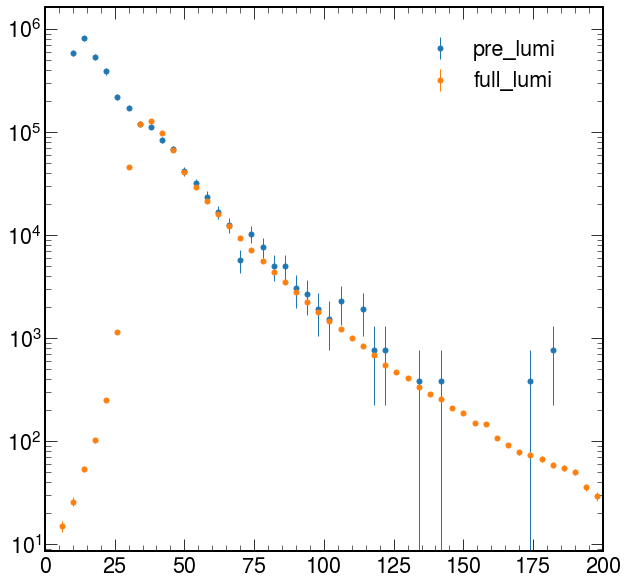

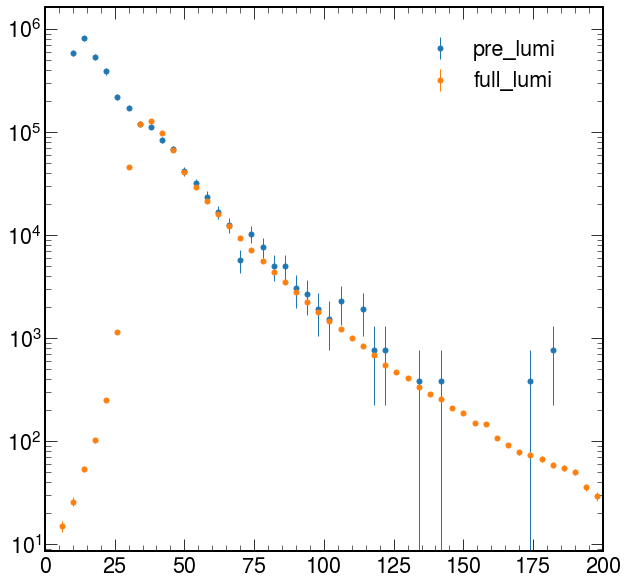

In [38]:
tight_pt_hist = yty_histplot('tight_pt_hist',1,np.linspace(0,200,50+1))
tight_pt_hist.append_values('pre_lumi',[pre_lumi_tight.pt[:,0]])

pre_lumi_weight = ak.ones_like(pre_lumi_tight.pt[:,0])*59.7/0.03891*(1*pre_lumi_tight.pt[:,0]>25) + ak.ones_like(pre_lumi_tight.pt[:,0])*59.7/0.00641*(1*pre_lumi_tight.pt[:,0]<=25)

tight_pt_hist.append_weights('pre_lumi',[pre_lumi_weight])
tight_pt_hist.append_values('full_lumi',[full_lumi_tight.pt[:,0]])

tight_pt_hist.set_legend(legendbool=True)
tight_pt_hist.set_log()
tight_pt_hist.draw(histtype_list=["errorbar","errorbar"])

In [ ]:
fake_pt_hist = yty_histplot('fake_pt_hist',1,np.linspace(0,200,50+1))

In [9]:
tc_filter

<Array [[True], [True], ... [True], [True]] type='148651 * var * bool'>

In [10]:
np.sum(tc_filter)

125265